<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/fixes/tutorials/Bonus_DeployModels/W2D4_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bonus Tutorial: Deploying Neural Networks on the Web

**By Neuromatch Academy**


__Content creators:__ Sam Ray, Vladimir Haltakov, Konrad Kording

__Production editors:__ Spiros Chavlis

---
# Tutorial Objectives

In this tutorial, you will learn the basics of how to deploy your deep learning models as web applications using some modern frameworks and libraries. In this tutorial, you will learn to:

 - Serve web pages with Flask
 - Apply the MVVM design pattern to write maintainable code
 - Create an interactive UI for your service
 - Deploy your deep learning models as a REST API
 - Deploying your application on Heroku

In [1]:
# @title Tutorial slides
from IPython.display import IFrame
link_id = "p6wty"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/p6wty/


---
# Setup

Run the following cells to install and include important dependencies.

In [2]:
# @title Install dependencies
!pip install --upgrade jupyter-client --quiet
!pip install Flask-RESTful flasgger pyngrok --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 29.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.6 MB/s eta 0:00:00


In [3]:
# @title Modified functions from the flask-ngrok package which doesn't work with the latest version of ngrok
import time
import json
import atexit
import requests
import subprocess
from threading import Timer


def _run_ngrok(port):
  ngrok = subprocess.Popen(["ngrok", 'http', str(port)])
  atexit.register(ngrok.terminate)
  localhost_url = "http://localhost:4040/api/tunnels"  # Url with tunnel details
  time.sleep(1)
  tunnel_url = requests.get(localhost_url).text  # Get the tunnel information
  j = json.loads(tunnel_url)

  tunnel_url = j['tunnels'][0]['public_url']  # Do the parsing of the get
  return tunnel_url


def start_ngrok(port):
  ngrok_address = _run_ngrok(port)
  print(f" * Running on {ngrok_address}")
  print(f" * Traffic stats available on http://127.0.0.1:4040")

def run_with_ngrok(app):
  """
  The provided Flask app will be securely exposed to the public internet
  via ngrok when run, and the its ngrok address will be printed to stdout
  :param app: a Flask application object
  :return: None
  """
  old_run = app.run

  def new_run(*args, **kwargs):
    port = kwargs.get('port', 5000)
    thread = Timer(1, start_ngrok, args=(port,))
    thread.setDaemon(True)
    thread.start()
    old_run(*args, **kwargs)
  app.run = new_run

In [4]:
# Imports
import io
import platform
from PIL import Image
from urllib.request import urlopen

import flasgger
from flask_restful import Api
from flask_restful import Resource, fields, marshal
from flask import Flask, render_template_string, request, redirect

import torch
from torchvision import models
import torchvision.transforms as transforms

## Setup ngrok

In order to be able to access the web app running in the notebook, we need to use a service called `ngrok`. Since recently, `ngrok` requires the user to register for a free account and setup an authentication token. Follow the steps below to set it up.

1. Go to [https://ngrok.com/](https://ngrok.com/) and create a free account. Do not forget to verify your e-mail address right after!
2. Go to [https://dashboard.ngrok.com/get-started/your-authtoken](https://dashboard.ngrok.com/get-started/your-authtoken) and copy your authtoken.
3. Paste it in the cell below by replacing `YOUR_NGROK_AUTHTOKEN`, uncomment the last line and run it.

You should see this output:

```python
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml
```

In [5]:
# Paste your ngrok authtoken below and run the cell

## Uncomment the line below
# !ngrok authtoken YOUR_NGROK_AUTHTOKEN

**Note:** If you want to delete at some point your account, visit this page [here](https://dashboard.ngrok.com/user/settings) and at the bottom of the page click on `Delete User`.

---
# Section 1: Introduction

In [6]:
# @title Video 1: Deploying Neural Networks on the Web
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'yQtPGtz4jDI'), ('Bilibili', 'BV1754y1E7Qf')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

We will start by building a simple web application in Flask, which we'll keep extending throughout the tutorial. In the end, you will have a web app where you can upload an image and have it classified automatically by a neural network model.

---
# Section 2: Flask

Flask is a web application micro-framework built with Python. Flask is popular because it's lightweight, easy to use, scalable, and has tons of great extensions. Nowadays, Flask is used for many different applications like web applications, REST APIs, socket-based services, and by companies like LinkedIn or Pinterest.

In this section, you will learn to create simple Flask websites.

## Section 2.1: Your First Flask App


In [7]:
# @title Video 2: Flask
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'uVqu-9IBIRg'), ('Bilibili', 'BV1sA411P7Rq')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

Creating a minimal Flask app is very simple. You need to create a `Flask` object and define the handler for the root URL returning the HTML response. You need to provide the applications module or package, but we can use `__name__` as a convenient shortcut.

We need one small trick because the app will be running in a notebook. If you just run the app, it will be accessible at `http://127.0.0.1:5000`. The problem is that this is a local address to the server where the notebook is running, so you can't access it. This is where `ngrok` helps - it creates a tunnel from the notebook server to the outside world. Make sure you use the ngrok URL when testing your app.

Uncommenting the `app.run()` command below, you will see this output:

```
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   WARNING: This is a development server. Do not use it in a production deployment.
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Running on https://XXX-XX-XX-XXX-XXX.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
```

The URL you have to visit is: `https://XXX-XX-XX-XXX-XXX.ngrok.io`

<br>

> **Note:** the call to `app.run()` will not return on its own. Make sure to stop the running cell when you want to move to the next one. You can do this by either clicking on the cell run/stop button or through _settings>Interrupt runtime_ or Ctrl+M+I.

> **Warning:** if the "visit site" option is not working, check the URL. `ngrok` redirects some links from `https` to `http`, so you have to manually make the change!

In [8]:
# Create a Flask app object
app = Flask(__name__)

# Define a function to be called when the user accesses the root URL (/)
# Handler
@app.route("/")
def home():
  # Return a very simple HTML response
  return "<h1>Welcome to Neuromatch</h1>"


# You need ngrok to expose the Flask app outside of the notebook
run_with_ngrok(app)

## Uncomment below to run the app
# app.run()

## Section 2.2: Using Jinja2 Templates

In [9]:
# @title Video 3: Jinja Templates
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'u25FfNIAKsg'), ('Bilibili', 'BV1Mb4y167eg')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

The default template engine used by Flask is Jinja2. Jinja2 offers features that help you write clean and reusable templates such as inheritance, humanizing, and formatting data (there's an extension for this), dividing components into sub-modules, etc.

In this section, we are going to add Jinja2 templates to the app. WIth Jinja2 you can use variables and control flow commands, like ifs and loops in your HTML code. Then you can pass data from your Python code to the template when it is rendered.

Let's first define the template of a simple web page showing some platform properties. We are going to loop over the `platform` dictionary containing property keys and their corresponding values:
```
{% for key, value in platform.items() %}
```
One row of the HTML table is created for every element of the dictionary. You can display the content of the variables like that: `{{ value }}`

In [10]:
# Jinja2 HTML template
template_str = '''
<html lang="en">
    <body>
        <div style="width: 50%; margin: 100px auto">
            <h1>Platform Info</h1>
            <table>
                <tr style="width:">
                    <th style="width: 200px">Property</th>
                    <th>Value</th>
                </tr>

                {% for key, value in platform.items() %}
                <tr>
                    <td style="width: 200px">{{ key }}</td>
                    <td>{{ value }}</td>
                </tr>
                {% endfor %}

            </table>
        </div>
    </body>
</html>
'''

You can then render the template passing the platform properties that you can retrieve using the `platform` package.

In [11]:
app = Flask(__name__)

@app.route("/")
def home():
  # Get the platform properties as a dict
  properties = platform.uname()._asdict()

  # Render the Jinja2 template
  return render_template_string(template_str, platform=properties)


run_with_ngrok(app)

## Uncomment below to run the app
# app.run()

## Section 2.3: Apply the MVVM Design Pattern

In [12]:
# @title Video 4: Using the MVVM Design Pattern
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '13bFN4L6c9I'), ('Bilibili', 'BV1YA411P766')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

Design patterns provide a way of writing reusable, adaptable, and extendable code. Design patterns are not libraries, but rather a set of best practices to follow when designing your software.

Model View View-Model (MVVM) is a powerful design pattern commonly used in web applications (and other GUI applications).
* **View** - this is that part of your code the user interacts with (the web page)
* **Model** - this is the representation of the data that you want to interact with.
* **View-Model** - this is the part that handles the application state and that transforms the data from the Model to a representation suitable for display and back.

<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D4_GenerativeModels/static/deploy.png">

Let's implement the MVVM pattern in Flask. You will first create classes for each of the 3 parts of the MVVM pattern used to display information about 2D points.

In [13]:
class PointModel:
  """
  Simple point Model storing a 2D point
  """

  # Initialize a 2D point
  def __init__(self, x, y):
    self.x = x
    self.y = y


class PointView(Resource):
  """
  Simple View displaying the information about a 2D point
  """

  def get(self):
    point = PointViewModel.get_sample_data()
    return f"Point: (x={point.x}, y={point.y})"


class PointViewModel:
  """
  ViewModel - Simple ViewModel retrieving the data and passing it to the view
  """

  # Create some sample data
  @classmethod
  def get_sample_data(cls):
    return PointModel(2, 5)

  # Register a handler for "/" in the API calling the PointView
  def setup(self, api):
    api.add_resource(PointView, '/')

You can now create your Flask app and use the `Api` object where you can register your ViewModel.

In [14]:
# Create a Flask app
app = Flask(__name__)

# Create an Api object where different ViewModels can be registered
api = Api(app)

# Create a PointViewModel and register it to the API
pvm = PointViewModel()
pvm.setup(api)

# Run with ngrok
run_with_ngrok(app)

## Uncomment below to run the app
# app.run()

## Section 2.4: Creating a REST API


In [15]:
# @title Video 5: REST API
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'cIjaEE6tKpk'), ('Bilibili', 'BV1A64y1z74c')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

REST (Representational State Transfer) is a set of rules according to which APIs are designed to enable your service to interact with other services. If HTML pages are interfaces designed for humans, you can think about REST APIs as interfaces made for computers.

A common way to implement a REST API is for your application to respond to certain requests by returning a JSON string containing the required data.

Let's now create a new View and ViewModel that will provide the platform properties in JSON format.

In [16]:
class PlatformView(Resource):
  """
  New view displaying some Platform Properties
  """

  def get(self):
    """
      This examples uses PlatformView Resource
      It works also with swag_from, schemas and spec_dict
      ---
      responses:
        200:
          description: A single Machine item
          schema:
            id: Machine
            properties:
              machine:
                type: string
                description: The type of the processor
                default: None
              node:
                type: string
                description: The name of the current virtual machine
                default: None
              processor:
                type: string
                description: The type of the processor arch
                default: None
              system:
                type: string
                description: The name of the user
                default: None
      """

    # Specification of the returned data
    resource_fields = {
        'system': fields.String,
        'machine': fields.String,
        'processor': fields.String,
        'node': fields.String
    }

    # Serialize the data according to the specification
    return marshal(platform.uname()._asdict(), resource_fields)


class PlatformViewModel:
  """
  A simple ViewModel that displays the PlatformView at /platform
  """

  def setup(self, api):
    api.add_resource(PlatformView, '/platform')

Note the documentation in the `get` method. We can use the `flasgger` package to automatically create documentation of your REST API. You can access it at `/apidocs`.

In [17]:
# Create the Flask app and register the ViewModel
app = Flask(__name__)
api = Api(app)
pvm = PlatformViewModel()
pvm.setup(api)

# Redirect / to /platform for convenience
@app.route('/')
def redirect_platform():
  return redirect("/platform", code=302)


# Register Swagger to create API documentation at /apidocs
swg = flasgger.Swagger(app)

# Run the app
run_with_ngrok(app)

## Uncomment below to run the app
# app.run()

---
# Section 3: Vue.js

In [18]:
# @title Video 6: Vue.js
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'PD6l9pkjw-c'), ('Bilibili', 'BV1Yv411K7GS')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

We already talked about the MVVM pattern and implemented it using a back end framework - Flask. Applying the same pattern on the front end can also be beneficial when creating dynamic applications.

Vue.js is a great front end library that implements the MVVM design pattern. It is widely used for creating user interfaces and single-page applications.

In this section, you will learn how to implement a simple Vue.js front end that fetches data from the platform REST API we created in the previous section.

## Section 3.1: Defining the Vue Template

We define our HTML template similarly to Jinja. The big difference is that the Vue template is rendered dynamically after the page is loaded, while the Jinja templates are rendered in the backend before the page is served.

Using variables is very similar to Jinja, but now you also have some JavaScript code handling the state of the application and the binding to the data. You can use the `axois` package to fetch data from our platform REST API, when Vue is initialized (mounted).

In [19]:
vue_template = """
<html>
    <head>
        <script src="https://cdn.jsdelivr.net/npm/vue/dist/vue.js"></script>
        <script src="https://cdnjs.cloudflare.com/ajax/libs/axios/0.21.1/axios.min.js"></script>
    </head>
    <body>

        <div id="app">
            <ul>
                <li><strong>System:    </strong>{{ platform.system }}</li>
                <li><strong>Machine:   </strong>{{ platform.machine }}</li>
                <li><strong>Processor: </strong>{{ platform.processor }}</li>
                <li><strong>Node:      </strong>{{ platform.node }}</li>
            </ul>
        </div>

        <script >
            var app = new Vue({
                el: '#app',
                data() {
                    return {
                        platform: null
                    }
                },
                mounted () {
                    axios.get('/platform')
                      .then(response => (this.platform = response.data))
                }
            });
        </script>

    </body>
</html>
"""

## Section 3.2: Serving the Vue.js App

You can now again run your Flask app and serve the Vue template from the root URL. We are still using Flask to implement our logic on the backend and provide the platform REST API.

This way of doing things may seem more complicated, but it has the advantage that it is dynamic. In the next section, we will add some dynamic functionality.

In [20]:
# Create the Flask app with the previously defined platform API
app = Flask(__name__)
api = Api(app)
# Serve the Platform REST API
pvm = PlatformViewModel()
pvm.setup(api)
swg = flasgger.Swagger(app)

# Serve the Vue template page at /
@app.route("/")
def home():
  return vue_template


# Run the app
run_with_ngrok(app)

## Uncomment below to run the app
# app.run()

---
# Section 4: Model Presentation

In [21]:
# @title Video 7: Deploying a PyTorch model
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '6UCLk37XWDs'), ('Bilibili', 'BV1Zb4y1z7aT')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

Now (finally) we have all the tools we need to deploy our neural network! We are going to use a pre-trained DenseNet mode. In the first step, we are going to create an API entry point that accepts an image as input and classifies it. After that, we will create a dynamic UI for easier interaction.

## Section 4.1: Image Classification API

In [22]:
# @title Video 8: Classification with a Pre-trained Model
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'UGByJ-_0whk'), ('Bilibili', 'BV1Dq4y1n7ks')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

First, we need to load a pre-trained DenseNet trained on ImageNet. You can use `torchvision.models` to quickly get a pre-trained model for many popular neural network architectures.

In [23]:
# Load a pre-trainied DenseNet model from torchvision.models
model = models.densenet121(pretrained=True)

# Switch the model to evaluation mode
model.eval()

# Load the class labels from a file
class_labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
class_labels = urlopen(class_labels_url).read().decode("utf-8").split("\n")

# Define the transformation of the input image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 116MB/s] 


Define a function to predict the most likely class using the model. Note that we need to pass a batch of images to the model. Since we have only 1, we can just use `unsqueeze(0)` to add an additional dimension.

In [24]:
def predict(model, transform, image, class_labels):
  # Transform the image and convert it to a tensor
  image_tensor = transform(image).unsqueeze(0)

  # Pass the image through the model
  with torch.no_grad():
    output = model(image_tensor)

  # Select the class with the higherst probability and look up the name
  class_id = torch.argmax(output).item()
  class_name = class_labels[class_id]

  # Return the class name
  return class_name

Let's test the `predict` function using an image of a [dog](https://unsplash.com/photos/2l0CWTpcChI/download?force=true&w=640).

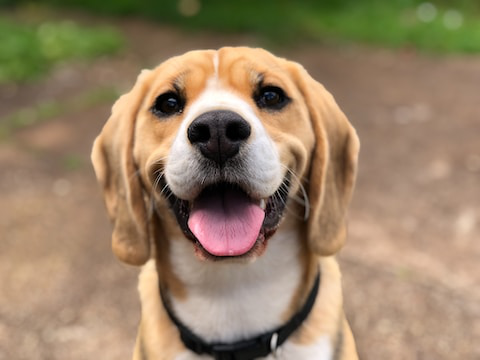

'English foxhound'

In [25]:
# Load and display the image
dog_image = Image.open(io.BytesIO(urlopen("https://unsplash.com/photos/2l0CWTpcChI/download?force=true&w=480").read()))
display(dog_image)

# Classify the image
display(predict(model, transform, dog_image, class_labels))

## Section 4.2: Create a Dynamic Application

In [26]:
# @title Video 9: Create a Dynamic Application
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'DJsK2bc9wuk'), ('Bilibili', 'BV1Vy4y1L7V9')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

We will now create a Flask app that receives an image at `/predict` and passes it through the model. We will also implement an interactive UI to upload the image and call the API.

The UI consists of a file upload field, a classify button, and an image displaying the uploaded file.

In [27]:
index_template = """
<html>
    <head>
        <!-- Load vue.js and axois.js -->
        <script src="https://cdn.jsdelivr.net/npm/vue/dist/vue.js"></script>
        <script src="https://cdnjs.cloudflare.com/ajax/libs/axios/0.21.1/axios.min.js"></script>
    </head>
    <body>
        <!-- The APP UI -->
        <div id="app" style="width: 50%; margin: 200px auto">
            <form id="imageForm" enctype="multipart/form-data" method="POST" style="text-align: center; display: block">
                <label for="imageFile">Select image to classify:</label
                ><input id="imageFile" name="file" type="file" style="margin-left: 10px" />

                <img v-if="image" :src="image" style="width: 250px; display: block; margin: 50px auto 10px" />
                <div v-if="prediction" style="font-size: 32px; font-weight: bold; text-align: center">
                    {{ prediction }}
                </div>
                <input v-if="image" type="submit" value="Classify Image" style="margin: 20px 20px" />
            </form>
        </div>

        <script>
            <!-- The Vue application -->
            var app = new Vue({
                el: "#app",
                data() {
                    return {
                        image: null,
                        prediction: null,
                    };
                },
            });

            <!-- Calling the predict API when the form is submitted -->
            document.getElementById("imageForm").addEventListener("submit", (e) => {
                axios
                    .post("/predict", new FormData(document.getElementById("imageForm")), {
                        headers: {
                            "Content-Type": "multipart/form-data",
                        },
                    })
                    .then((response) => (app.prediction = response.data));

                e.preventDefault();
            });

            <!-- Display the selected image -->
            document.getElementById("imageFile").addEventListener("change", (e) => {
                const [file] = document.getElementById("imageFile").files;
                if (file) {
                    app.image = URL.createObjectURL(file);
                }
            });
        </script>
    </body>
</html>
"""

The application has two entry points:

* `/` - serve the Vue template with the interactive UI
* `/predict` - a REST API classifying the image received as input

In [28]:
app = Flask(__name__)

# Serve the Vue template with the interactive UI
@app.route("/")
def home():
  return index_template


# Classification API
@app.route("/predict", methods=['POST'])
def predict_api():
  # Fetch the image from the request and convert it to a Pillow image
  image_file = request.files['file']
  image_bytes = image_file.read()
  image = Image.open(io.BytesIO(image_bytes))

  # Predict the class from the image
  class_name = predict(model, transform, image, class_labels)

  # Return the result
  return class_name


# Run the app
run_with_ngrok(app)

## Uncomment below to run the app
# app.run()

---
# Section 5: Deploy a Flask app on Heroku

In [29]:
# @title Video 10: Deploy on Heroku
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'kaf6z-tAxCY'), ('Bilibili', 'BV1oo4y1S77Z')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

Now you are going to deploy your application as a real web server outside of the notebook. We are going to use Heroku for this. Heroku is a PaaS (Platform-as-a-Service) that offers pre-configured environments so you can deploy an application easily and quickly. They also offer a free tier which is enough for deploying simple apps.

But first, you need to test your application locally.

## Section 5.1: Preparing Your Environment


In [30]:
# @title Video 11: Prepare Python Environment
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'IMd_sRm4fJM'), ('Bilibili', 'BV1bv411K7dP')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

You need to do all the steps from here on on your own machine and not in the notebook. You need to make sure that you have Python 3 installed and some code editor (for example VS Code). You will also be using the terminal a lot in this section.

First, you need to prepare your Python environment and install all required dependencies. You should first create an empty folder where you will store your application and do the following steps.

**1. Create a new virtual environment**

Run the following code in the terminal to create a new Python virtual environment:
```
python -m venv .venv
```

**2. Activate the virtual environment**

Now, you need to activate the environment, which is a bit different on Linux/macOS and Windows.

For Linux and macOS:
```
source .venv/bin/activate
```

For Windows:
```
.venv\Scripts\activate.bat
```


**3. Install dependencies**

You need to install some packages that you will need using `pip`:
```
pip install flask Pillow gunicorn
```

> Note: the package `gunicorn` is a web server that is needed later when your code runs on Heroku.


**4. Install PyTorch**

Depending on your system, there are different ways to install `torch` and `torchvision`. Refer to the [Installation page](https://pytorch.org/get-started/locally/) for the exact command. We recommend using `pip`.

On macOS and Windows for example this is straightforward:
```
pip install torch torchvision
```

> Note: avoid installing `torchaudio` since it is not needed, but may cause problems with the package size when deploying on Heroku later.


## Section 5.2: Create Your Application

In [31]:
# @title Video 12: Creating a Local Application
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'fF1fmIXz5NQ'), ('Bilibili', 'BV1bM4y157xK')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

You are now ready to create the files needed for your application. For now, you need just 2 files.

**`app.py`**

This is the main file of your application. Inside, you will put the code for running your PyTorch model as well as the code of your Flask application.


```python
import os
import io
import torch
from urllib.request import urlopen
from PIL import Image
from torchvision import models
import torchvision.transforms as transforms
from flask import Flask, request, send_from_directory

# Load a pre-trainied DenseNet model from torchvision.models
model = models.densenet121(pretrained=True)
model.eval()

# Load the class labels from a file
class_labels_url = (
    "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
)
class_labels = urlopen(class_labels_url).read().decode("utf-8").split("\n")

# Define the transofrmation of the input image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def predict(model, transform, image, class_labels):
  # Transform the image and convert it to a tensor
  image_tensor = transform(image).unsqueeze(0)

  # Pass the image through the model
  with torch.no_grad():
      output = model(image_tensor)

  # Select the class with the higherst probability
  class_id = torch.argmax(output).item()
  class_name = class_labels[class_id]
  return class_name


app = Flask(__name__)

@app.route("/")
def home():
  return send_from_directory("static", "index.html")


@app.route("/predict", methods=["POST"])
def predict_api():
  # Fetch the image from the request and convert it
  image_file = request.files["file"]
  image_bytes = image_file.read()
  image = Image.open(io.BytesIO(image_bytes))

  # Predict the class from the image
  class_name = predict(model, transform, image, class_labels)

  # Write result as JSON
  return class_name


# Run the app
if __name__ == "__main__":
  app.run(debug=False, threaded=True, port=os.getenv("PORT", 5000))
```

**static/index.html**

This file should contain the HTML code of your Vue template - exactly as it is.

```html
<html>
    <head>
        <!-- Load vue.js and axois.js -->
        <script src="https://cdn.jsdelivr.net/npm/vue/dist/vue.js"></script>
        <script src="https://cdnjs.cloudflare.com/ajax/libs/axios/0.21.1/axios.min.js"></script>
    </head>
    <body>
        <!-- The APP UI -->
        <div id="app" style="width: 50%; margin: 200px auto">
            <form id="imageForm" enctype="multipart/form-data" method="POST" style="text-align: center; display: block">
                <label for="imageFile">Select image to classify:</label
                ><input id="imageFile" name="file" type="file" style="margin-left: 10px" />

                <img v-if="image" :src="image" style="width: 250px; display: block; margin: 50px auto 10px" />
                <div v-if="prediction" style="font-size: 32px; font-weight: bold; text-align: center">
                    {{ prediction }}
                </div>
                <input v-if="image" type="submit" value="Classify Image" style="margin: 20px 20px" />
            </form>
        </div>

        <script>
            <!-- The Vue application -->
            var app = new Vue({
                el: "#app",
                data() {
                    return {
                        image: null,
                        prediction: null,
                    };
                },
            });

            <!-- Calling the predict API when the form is submitted -->
            document.getElementById("imageForm").addEventListener("submit", (e) => {
                axios
                    .post("/predict", new FormData(document.getElementById("imageForm")), {
                        headers: {
                            "Content-Type": "multipart/form-data",
                        },
                    })
                    .then((response) => (app.prediction = response.data));

                e.preventDefault();
            });

            <!-- Display the selected image -->
            document.getElementById("imageFile").addEventListener("change", (e) => {
                const [file] = document.getElementById("imageFile").files;
                if (file) {
                    app.image = URL.createObjectURL(file);
                }
            });
        </script>
    </body>
</html>
```

## Section 5.3: Testing Your Application Locally

You are now ready to test your application. Once you have your environment set up correctly and your application files created you can just start it:
```
python app.py
```

You can now access your application at http://127.0.0.1:5000. No `ngrok` needed anymore!

## Section 5.4: Preparing for Deployment on Heroku

In [32]:
# @title Video 13: Preparing for Heroku
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'L2W0C7nMttI'), ('Bilibili', 'BV1Nq4y1Q71H')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

Before we can deploy on Heroku there are a couple of things we need to prepare.

**Create `Procfile`**

Every application running on Heroku needs a `Procfile` where you need to specify how the app should be run. In our case, it is quite easy, because we can use `gunicorn` as a web server. Create a file named `Procfile` in the root folder of your application and put the following code inside:
```
web: gunicorn app:app
```

**Create `requirements.txt`**

We also need to tell Heroku which Python packages need to be installed. Heroku uses the standard way of defining Python dependencies - a `requirements.txt` file. You can create it with the following command:
```
pip freeze > requirements.txt
```

**Fix the `torch` version**

Now, this should be enough in theory, but we need one small change. The problem is that by default `torch` comes with both the CPU and GPU code, which creates a package that exceeds the maximum size limit on the Heroku free tier. Therefore we need to make sure that we only specify the CPU version of `torch`.

You need to open the `requirements.txt` file and modify it as follows:
1. Add the following line in the beginning, telling Heroku where to look for the packages `-f https://download.pytorch.org/whl/torch_stable.html
`
2. Find the line defining the torch dependency and change it to `torch==1.9.0+cpu`
3. Do the same with `torchvision` by changing it to `torchvision==0.10.0+cpu
`

## Section 5.5: Deploying on Heroku

In [33]:
# @title Video 14: Deploying on Heroku
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'Ni9YKotZUQk'), ('Bilibili', 'BV1P64y1z7cU')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

You are now finally ready to deploy to Heroku! There are just a couple of steps needed.

**1. Create a Heroku account**

Create a free account on Heroku at https://www.heroku.com/


**2. Install the Heroku CLI**

Use [this guide](https://devcenter.heroku.com/articles/heroku-cli) to install the Heroku CLI for your system. After installation, you should be able to run the `heroku` command in your terminal.

**3. Login to Heroku**

Run the following command in the terminal and log in:
```
heroku login
```

**4. Create a new Heroku App**

Run the following command to create a new application. When choosing the application name, you need to make sure that it doesn't exist yet. It may be a good idea to add your name to it (I chose `vladimir-classifier-app`).
```
heroku create <application name>
```

**5. Initialize a Git repository**

The deployment on Heroku is done using `git`. If you don't have it installed already, check [this guide](https://git-scm.com/book/en/v2/Getting-Started-Installing-Git). You need to initialize a new repository, commit your files and push it to Heroku:

```
git init
git add app.py Procfile requirements.txt static
git commit -m "Initial commit"
heroku git:remote -a <application name>
git push heroku master
```

Your application will now be packaged and uploaded to Heroku. This may take a couple of minutes, but when done you will be able to access your application at https://&lt;application name>.herokuapp.com.

You can also go to your dashboard and see your application there: https://dashboard.heroku.com/apps.

---
# Summary

In [34]:
# @title Video 15: Summary
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'pDLdNOuUtKk'), ('Bilibili', 'BV1Qg411L7RM')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In this tutorial you learned the basics of some modern tools for creating dynamic web applications and REST APIs. You also learned how you can deploy your neural network model as a web app.

You can now build on top of that and create more sophisticated and awesome applications and make them available to millions of people!